In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Replace with your actual file path
file_path = '/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/Health_and_Personal_Care.jsonl'

# Load the .jsonl file into a pandas DataFrame
df = pd.read_json(file_path, lines=True)

# Display the first 5 rows of the DataFrame
print("DataFrame Loaded Successfully!")
df.head()


DataFrame Loaded Successfully!


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True
2,5,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2019-07-24 11:13:58.905,0,True
3,4,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,2022-09-04 02:29:02.725,7,True
4,1,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:53:07.262,0,True


In [ ]:
# number of reviews
print(len(df))

print(list(df.columns))

494121
['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [ ]:
# count of all ratings to check if there's imbalance
df['rating'].value_counts()

,count
rating,
5,301713
1,69564
4,57000
3,36949
2,28895


There seems to be a class imbalance. 5 star reviews seem to dominate a lot.

In [ ]:
df.isnull().sum()

,0
rating,0
title,0
text,0
images,0
asin,0
parent_asin,0
user_id,0
timestamp,0
helpful_vote,0
verified_purchase,0


There doesn't seem to be any null values.

In [2]:
!pip uninstall gensim numpy -y

# Reinstall gensim - pip will pull in a compatible numpy
!pip install gensim

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [3]:
# --- Installations and Imports ---
# No specific install needed if using standard Colab Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional # Added Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import gensim # Assumes ft_model is loaded using this
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import os
from tqdm.notebook import tqdm

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight # To calculate class weights
import time

print(f"TensorFlow Version: {tf.__version__}")
# Check for GPU
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU detected: {gpu_devices}")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True) # Prevent TF from allocating all GPU memory at once
else:
    print("WARNING: No GPU detected. Training will be very slow.")

TensorFlow Version: 2.18.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocessing

In [ ]:
df.dropna(subset=['text', 'rating'], inplace=True)
print(f"\nDataFrame shape after dropping rows with missing text/rating: {df.shape}")

# Combine 'title' and 'text'
# Fill missing titles with an empty string BEFORE concatenation
df['title'] = df['title'].fillna('')
df['review_full'] = df['title'] + ' ' + df['text']

# Text Cleaning Setup
nltk.download('punkt_tab', quiet=True) # Download the specific resource needed
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercasing
    text = text.lower()
    # 2. Remove HTML tags (if any)
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove punctuation and special characters (keeping only letters and whitespace)
    text = re.sub(r'[^a-z\s]', '', text)
    # 4. Tokenization
    tokens = word_tokenize(text)
    # 5. Remove Stop Words and Lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1] # Keep words with length > 1
    # 6. Join back into string
    return ' '.join(cleaned_tokens)

print("\nStarting text cleaning (this may take a while)...")
# Apply cleaning function - Monitor progress if needed for large datasets
# Consider df['review_full'].parallel_apply(clean_text) using libraries like pandarallel if speed is critical
df['review_cleaned'] = df['review_full'].apply(clean_text)
print("Text cleaning completed.")

# Drop rows where cleaning might have resulted in empty strings
df.dropna(subset=['review_cleaned'], inplace=True)
df = df[df['review_cleaned'].str.strip() != ''] # Ensure no empty strings after cleaning
print(f"DataFrame shape after cleaning and removing empty reviews: {df.shape}")


DataFrame shape after dropping rows with missing text/rating: (494121, 11)

Starting text cleaning (this may take a while)...
Text cleaning completed.
DataFrame shape after cleaning and removing empty reviews: (493820, 12)


In [ ]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,review_full,review_cleaned
0,4,12 mg is 12 on the periodic table people! Mg f...,This review is more to clarify someone else’s ...,[],B07TDSJZMR,B07TDSJZMR,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,2020-02-06 00:49:35.902,3,True,12 mg is 12 on the periodic table people! Mg f...,mg periodic table people mg magnesium review c...
1,5,Save the lanet using less plastic.,Love these easy multitasking bleach tablets. B...,[],B08637FWWF,B08637FWWF,AEVWAM3YWN5URJVJIZZ6XPD2MKIA,2020-11-02 22:03:06.880,3,True,Save the lanet using less plastic. Love these ...,save lanet using less plastic love easy multit...
2,5,Fantastic,I have been suffering a couple months with hee...,[],B07KJVGNN5,B07KJVGNN5,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2019-07-24 11:13:58.905,0,True,Fantastic I have been suffering a couple month...,fantastic suffering couple month heel pain pla...
3,4,It holds the water and makes bubbles. That's ...,"It's cheap and it does what I wanted. The ""ma...",[],B007HY7GC2,B092RP73CX,AEZGPLOYTSAPR3DHZKKXEFPAXUAA,2022-09-04 02:29:02.725,7,True,It holds the water and makes bubbles. That's ...,hold water make bubble thats bought cheap want...
4,1,Not for me,Didn't do a thing for me. Not saying they don'...,[],B08KYJLF5T,B08KYJLF5T,AEQAYV7RXZEBXMQIQPL6KCT2CFWQ,2022-01-20 23:53:07.262,0,True,Not for me Didn't do a thing for me. Not sayin...,didnt thing saying dont


Saving the processed data frame in a file (pickle, parquet and csv) as a checkpoints.

In [ ]:
df.to_pickle('/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/reviews_with_full_column.pkl')

In [ ]:
df.to_parquet('/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/reviews_with_full_column.parquet')

In [ ]:
df.to_csv('/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/reviews_with_full_column.csv', index=False)

In [4]:
import pandas as pd

# Load the parquet file
df = pd.read_parquet('/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/reviews_with_full_column.parquet')

# --- 4. Data Splitting ---

In [5]:
# Define Features (X) and Target (y)
X = df['review_cleaned']
y = df['rating']
print("Splitting data into Training and Testing sets (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# --- Target Variable Adjustment (0-4 for Keras) ---
# Important for sparse_categorical_crossentropy
y_train_adj = y_train - 1
y_test_adj = y_test - 1
num_classes = len(y_train.unique()) # Should be 5
print(f"\nAdjusted labels for Keras (0 to {num_classes-1}).")


Splitting data into Training and Testing sets (80/20)...
Training set size: 395056 samples
Testing set size: 98764 samples

Adjusted labels for Keras (0 to 4).


# --- Keras Tokenization and Padding ---

In [6]:
# Hyperparameters for tokenization/padding
MAX_NUM_WORDS = 20000  # Max vocabulary size for the model
MAX_SEQUENCE_LENGTH = 200 # Max length of sequences (reviews) - adjust based on your data

print(f"\nTokenizing text (max_words={MAX_NUM_WORDS})...")
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>") # Handle out-of-vocabulary words
tokenizer.fit_on_texts(X_train) # Fit ONLY on training data

print("Converting texts to sequences...")
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

print(f"Padding sequences to max length {MAX_SEQUENCE_LENGTH}...")
X_train_pad = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Padded training sequences shape: {X_train_pad.shape}")
print(f"Padded testing sequences shape: {X_test_pad.shape}")


Tokenizing text (max_words=20000)...
Converting texts to sequences...
Found 149459 unique tokens.
Padding sequences to max length 200...
Padded training sequences shape: (395056, 200)
Padded testing sequences shape: (98764, 200)


# --- Load FastText Embeddings ---

In [ ]:
import os # For file path handling
import gzip # For potential .gz files
import requests # For downloading
from tqdm.notebook import tqdm # Progress bar for loops

In [7]:
import gensim.downloader as api
import time
import numpy as np # Needed for np.zeros if vectorization fails

# --- Load FastText Embeddings via Gensim Downloader ---

print("\nAttempting to load 'fasttext-wiki-news-subwords-300' via gensim downloader...")
print("(Download might take a while on the first run, model size is < 1GB)")

ft_model = None # Initialize ft_model to None
vector_size = 0 # Initialize vector_size
start_load = time.time()

try:
    # This command handles download and loading automatically
    ft_model = api.load("fasttext-wiki-news-subwords-300")
    vector_size = ft_model.vector_size # Should be 300
    print(f"\nModel 'fasttext-wiki-news-subwords-300' loaded successfully in {time.time() - start_load:.2f} seconds.")
    print(f"Vector size: {vector_size}")

except Exception as e:
    print(f"\nERROR loading model via gensim downloader: {e}")
    print("Please check your internet connection or the model name.")
    ft_model = None # Ensure ft_model is None if loading failed

# --- Check if loaded ---
if ft_model is None:
    print("\n############################################")
    print("WARNING: FastText model loading failed. Subsequent steps using 'ft_model' will not work.")
    print("############################################")
else:
    # You might need to check the structure here depending on how you use it later.
    # For direct access like model['word'], this loaded object usually works directly.
    # No separate .wv is typically needed for models loaded this way.
    print("\nFastText model seems loaded and ready.")


Attempting to load 'fasttext-wiki-news-subwords-300' via gensim downloader...
(Download might take a while on the first run, model size is < 1GB)
[==================================================] 100.0% 958.5/958.4MB downloaded

Model 'fasttext-wiki-news-subwords-300' loaded successfully in 321.65 seconds.
Vector size: 300

FastText model seems loaded and ready.


# --- Load FastText Model (Ensure this was run previously) ---

In [8]:
# Assume 'ft_model' (gensim loaded model) and 'vector_size' exist
# If not, include the loading code here again.
# Example check:
if 'ft_model' not in locals() or ft_model is None:
     print("ERROR: FastText model ('ft_model') not found. Please load it first.")
     # exit() # Or load it here
else:
    print(f"\nUsing pre-loaded FastText model with vector size: {vector_size}")



Using pre-loaded FastText model with vector size: 300


# --- Create Embedding Matrix ---

In [9]:
# Prepare embedding matrix to initialize Keras Embedding layer
print("Creating embedding matrix from FastText model...")
num_words_in_keras_tokenizer = min(MAX_NUM_WORDS, len(word_index)) + 1 # +1 for padding token 0
embedding_matrix = np.zeros((num_words_in_keras_tokenizer, vector_size))
oov_count = 0

for word, i in tqdm(word_index.items(), desc="Building Matrix"):
    if i >= MAX_NUM_WORDS: # Only consider words within the MAX_NUM_WORDS limit
        continue
    if ft_model:
        try:
            # Check if word exists in FastText model directly
            if word in ft_model:
                 embedding_vector = ft_model[word]
                 embedding_matrix[i] = embedding_vector
            else:
                oov_count += 1 # Word in tokenizer vocab but not in FastText
        except Exception as e:
            # Should not happen if 'word in ft_model' check works, but safety
            print(f"Error accessing vector for word '{word}': {e}")
            oov_count += 1
    else:
        # Should not happen if ft_model check passed, but safety
        pass

print(f"Embedding matrix shape: {embedding_matrix.shape}")
print(f"Number of OOV words (in top {MAX_NUM_WORDS} but not in FastText): {oov_count}")

Creating embedding matrix from FastText model...


Building Matrix:   0%|          | 0/149459 [00:00<?, ?it/s]

Embedding matrix shape: (20001, 300)
Number of OOV words (in top 20000 but not in FastText): 2472


# --- Build Keras Model ---

In [10]:
print("\nBuilding Keras BiLSTM model (2 layers)...")

# Make sure num_classes, num_words_in_keras_tokenizer, vector_size,
# MAX_SEQUENCE_LENGTH, and embedding_matrix are defined from previous steps

model = Sequential([
    # Embedding Layer - Initialize with FastText weights
    Embedding(input_dim=num_words_in_keras_tokenizer,
              output_dim=vector_size,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False), # Keep embeddings frozen initially

    # First BiLSTM layer
    Bidirectional(LSTM(units=100, return_sequences=True)), # return_sequences=True to feed the next LSTM
    Dropout(0.1), # Specified dropout

    # Second BiLSTM layer
    Bidirectional(LSTM(units=200, return_sequences=False)), # return_sequences=False before the final Dense
    Dropout(0.1), # Specified dropout

    # Dense Output Layer - CORRECTED TO 5 NEURONS
    Dense(num_classes, activation='softmax') # num_classes = 5 for ratings 1-5
])

model.summary()


Building Keras BiLSTM model (2 layers)...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,000,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,000,300 (22.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,000,300 (22.89 MB)

# --- Compile Model ---

In [11]:
print("\nCompiling model...")

# Use Adam optimizer with specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04) # 0.0001

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


Compiling model...


# --- Calculate Class Weights for Imbalance ---

In [12]:
print("Calculating class weights...")
# Ensure labels are 0-4 for calculation
unique_classes = np.unique(y_train_adj)
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_adj
)
# Keras expects a dictionary mapping class index to weight
class_weights_dict = dict(zip(unique_classes, class_weights_array))
print(f"Class weights: {class_weights_dict}")


Calculating class weights...
Class weights: {0: 1.4201707558191785, 1: 3.4183265553344295, 2: 2.6739043622457612, 3: 1.7334620447564721, 4: 0.32760533713688644}


# --- Train Model ---

In [13]:
print("\nTraining model...")
EPOCHS = 10 # As requested
BATCH_SIZE = 200 # As requested

# Optional: Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True) # Keep patience=2 or adjust

history = model.fit(X_train_pad, y_train_adj,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_pad, y_test_adj),
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

print("Model training finished.")

# <<< --- NEW SECTION: Save the Trained Model --- >>>
print("\nSaving the trained model as a checkpoint...")

# Define the path in your Google Drive (ensure Drive is mounted)
# Make sure the directories exist or create them beforehand if needed
model_save_path = "/content/drive/MyDrive/DADM/Main_Assignment_Shared_resources/Mervin/Main_Assignment/saved_models/bilstm_fasttext_rating_model.keras" # Using .keras format

try:
    # Ensure the directory exists (optional, but good practice)
    import os
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

    # Save the entire model (architecture, weights, optimizer state)
    model.save(model_save_path)
    print(f"Model checkpoint saved successfully to: {model_save_path}")

except Exception as e:
    print(f"ERROR saving model checkpoint: {e}")
    print("Please ensure Google Drive is mounted and the path is correct.")

# <<< --- END OF SAVE SECTION --- >>>


Training model...
Epoch 1/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 301s 149ms/step - accuracy: 0.4785 - loss: 1.3579 - val_accuracy: 0.5281 - val_loss: 1.1770
Epoch 2/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 298s 151ms/step - accuracy: 0.6046 - loss: 1.1488 - val_accuracy: 0.5952 - val_loss: 1.0327
Epoch 3/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 323s 151ms/step - accuracy: 0.6421 - loss: 1.0699 - val_accuracy: 0.6280 - val_loss: 0.9280
Epoch 4/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 321s 151ms/step - accuracy: 0.6480 - loss: 1.0543 - val_accuracy: 0.6764 - val_loss: 0.8757
Epoch 5/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 321s 151ms/step - accuracy: 0.6544 - loss: 1.0391 - val_accuracy: 0.6795 - val_loss: 0.8569
Epoch 6/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 323s 151ms/step - accuracy: 0.6572 - loss: 1.0301 - val_accuracy: 0.6382 - val_loss: 0.9265
Epoch 7/10
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 322s 151ms/step - accuracy: 0.6589 - loss: 1.0263 - val_accuracy: 0.6580 - val_loss: 0.8849
Model training finished.

Saving the traine

# --- Evaluate Model ---

In [14]:

print("\nEvaluating model on test data...")
loss, accuracy = model.evaluate(X_test_pad, y_test_adj, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Generate Classification Report ---
print("\nGenerating classification report...")
# Get probability predictions
y_pred_probs = model.predict(X_test_pad)
# Get class index predictions
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Use original labels (1-5) for report if desired, or adjusted (0-4)
# Using adjusted labels (0-4) here to match y_test_adj
print(classification_report(y_test_adj, y_pred_classes, target_names=[str(i) for i in range(num_classes)], zero_division=0))

# Confusion Matrix (using adjusted labels 0-4)
print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test_adj, y_pred_classes),
                   index=[f'Actual_{i}' for i in range(num_classes)],
                   columns=[f'Predicted_{i}' for i in range(num_classes)]))



Evaluating model on test data...
Test Loss: 0.8569
Test Accuracy: 0.6795

Generating classification report...
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 47s 15ms/step
              precision    recall  f1-score   support

           0       0.69      0.68      0.69     13909
           1       0.28      0.42      0.34      5779
           2       0.36      0.40      0.38      7387
           3       0.34      0.48      0.40     11395
           4       0.90      0.78      0.83     60294

    accuracy                           0.68     98764
   macro avg       0.51      0.55      0.53     98764
weighted avg       0.73      0.68      0.70     98764


Confusion Matrix:
          Predicted_0  Predicted_1  Predicted_2  Predicted_3  Predicted_4
Actual_0         9466         2445          823          410          765
Actual_1         1495         2409          992          471          412
Actual_2          791         1409         2968         1428          791
Actual_3          377          716      

# --- Optional: Plot Training History ---

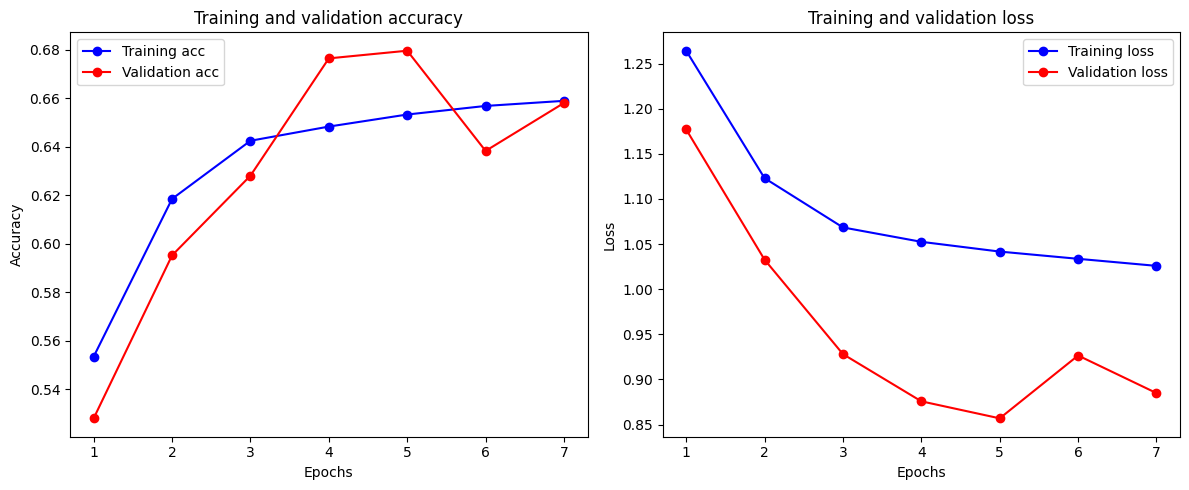


--- Script Finished ---


In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo-', label='Training acc')
  plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo-', label='Training loss')
  plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(history)

print("\n--- Script Finished ---")